In [405]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy import interpolate


In [573]:
#Extractor de frames de un video (esto ya lo habia hecho en una tarea pasada)
class FrameExtractor:
    
    def __init__(self,path):
        vc = cv2.VideoCapture(path)
        #Obtenemos el número de imágenes del video
        nFrames = 0
        #La frecuencia de muestreo
        fRate = vc.get(cv2.CAP_PROP_FPS)
        self.fRate = fRate
        #Leempos la captura de video
        ret,f = vc.read()
        n = f.shape[0]
        m = f.shape[1]
        #Creamos el stack de imágenes
        self.frameStack = []
        self.n = n
        self.m = m
        i = 0
        #Vamos a extraer todos los frames y se almacenaran en una pila de imagenes 
        #frame stack
        while(True):
            ret,f = vc.read()
            if(ret):
                self.frameStack.append(cv2.cvtColor(f, cv2.COLOR_BGR2GRAY))
                nFrames += 1
            else:
                break
        self.nFrames = nFrames
        vc.release()
        
    #Obtiene el frame especificado en index
    def getImg(self,index):
        if(index > self.nFrames-1):
            print("Index is out of bounds")
        else:
            return self.frameStack[index]
        
    #Obtiene el stack de imágenes
    def getImgStack(self):
        return self.frameStack
    
    #Getters para las dimensiones de la imagen
    def getHeight(self):
        return self.n
    
    def getWidth(self):
        return self.m
    
    def getFrameRate(self):
        return self.fRate
    
    def getNumberOfFrames(self):
        return self.nFrames
    
    def getDeltaT(self):
        return 1/self.fRate
    
    def getTArray(self,initialFrame):
        duration = (self.getNumberOfFrames()-initialFrame-1)*self.getDeltaT()
        return np.arange(0,duration,self.getDeltaT())

In [574]:
#Vamos a verificar que si podamos abrir los frames del video 
videoFrames = FrameExtractor("Muestra-2.mp4")

Text(0.5, 1.0, 'Frame 18')

<Figure size 432x288 with 0 Axes>

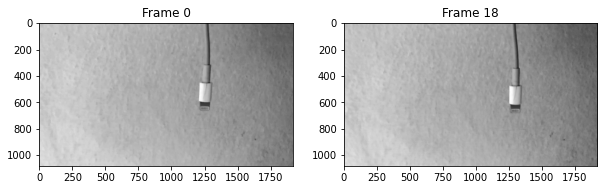

In [575]:
plt.figure()
fig, ax = plt.subplots(1,2,figsize=(10, 3.5))
ax[0].imshow(videoFrames.getImg(0),cmap = 'gray')
ax[0].set_title('Frame 0')
ax[1].imshow(videoFrames.getImg(917),cmap= 'gray')
ax[1].set_title('Frame 18')

In [601]:
#Voy a seguir una metoddología parecida a la que se plantea el articulo, donde se detectan características
# y se hace el tracking de las mismas usando flujo óptico 

class FeatureTracker:
    
    def __init__(self, frameExtractor):
        self.frameExtractor = frameExtractor
    
    #Detect features 
    def detectFeatures(self,initialIndex ):
        self.initialIndex = initialIndex
        initialImage = self.frameExtractor.getImg(initialIndex).copy()
        #Vamos a usar los valores que vienen en los ejemplos de open cv
        qualityLevel = 0.01
        maxCorners = 25
        minDistance = 20
        
        self.features = cv2.goodFeaturesToTrack(initialImage, maxCorners, qualityLevel, minDistance)
        self.numberOfFeatures = len(self.features)
        for i in self.features:
            x,y = i.ravel()
            cv2.circle(initialImage,(x,y),10,255,-1)
        self.featuresImage = initialImage
            
    
    def plotFeaturesToTrack(self):
        plt.figure()
        plt.title("Características a seguir")
        #Mostramos la imagen 
        plt.imshow(self.featuresImage,cmap = "gray")
        #Mostramos los puntos
        
    #Suponiendo que ya tenemos las características ahora debemos usar Lukas Kanade
    
    
    def lukasKanadeTrack(self):
        oldPic = self.frameExtractor.getImg(self.initialIndex)
        trajectories = np.zeros((self.frameExtractor.getNumberOfFrames()-self.initialIndex-1,2,self.numberOfFeatures))
        previousPoints = self.features
        for i in range(self.initialIndex+1,self.frameExtractor.getNumberOfFrames()):
            nextImage = self.frameExtractor.getImg(i)
            nextFeatures, stat, err = cv2.calcOpticalFlowPyrLK(oldPic, nextImage, previousPoints,None)
            #Almacenamos las nuevas posiciones de las características. 
            for j in range(0,len(nextFeatures)):
                feature = nextFeatures[j]
                x,y = feature.ravel()
                trajectories[i-self.initialIndex-1,0,j] = x
                trajectories[i-self.initialIndex-1,1,j] = y
                
            previousPoints = nextFeatures
            oldPic = nextImage
        self.trajectories = trajectories
    #Graficamos el track de la i-ésima característica. aquí lo que queremos realmente es graficar
    #una animación del track
    def plotTrack(self,trackIndex,seconds):
        self.fig, self.ax = plt.subplots()
        self.plotTrackIndex = trackIndex
        #Convertimos a milisegundas el delta de tiempo entre cuadro y cuadro
        deltaT = self.frameExtractor.getDeltaT()*(10 **3)
        
        numFrames = int(np.floor(seconds/self.frameExtractor.getDeltaT()))
        fr = range(self.initialIndex,self.initialIndex + numFrames-1)
        anim = FuncAnimation(self.fig, self.plotDot, frames = fr, interval = deltaT, blit = False)
        return HTML(anim.to_html5_video())
    
    def plotDot(self, i):
        
        vector = self.trajectories[i,:,self.plotTrackIndex]
        self.ax.clear()
        self.ax.set_title("Seguimiento de la característica "+str(self.plotTrackIndex))
        self.ax.imshow(self.frameExtractor.getImg(i),cmap = "gray")
        self.ax.plot(vector[0],vector[1],marker = 'o',markersize = 10, color = 'red')
        
    #Aquí se va a verificar cuales de las caracteristicas tienen valores que no cambien de un momento a otro
    #y las vamos a eliminar
    def cleanFeatures(self):
        valid = []
        for i in range(0,self.getNumberOfFeatures()):
            x = self.trajectories[:,0,i]
            y = self.trajectories[:,1,i]
            
            isValid = True
            
            for j in range(0,len(x)-2):
                if(x[j] == x[j+1] and y[j] == y[j+1]):
                    isValid = False
            
            if(isValid):
                valid.append(i)
            else:
                print("cleaned "+str(i))
        
        self.numberOfFeatures = len(valid)
        newTrajectories = np.zeros((np.size(self.trajectories, 0), 2, self.numberOfFeatures))
        for i in range(0,self.getNumberOfFeatures()):
            
            x = self.trajectories[:,0,valid[i]]
            y = self.trajectories[:,1,valid[i]]
            newTrajectories[:,0,i] = x
            newTrajectories[:,1,i] = y
        
        self.trajectories = newTrajectories
            
        
    
    #Hecho esto tenemos que hacer un resampleo, ya que un ECG generalmente va a estar
    #captando a una frecuencia de muestreo de 250 Hz, mientras que nuestra cámara lo hace
    #a una frecuencia de 30 Hz. En el articulo lo que mencionan es que habría que usar
    #algo que se llama interpolación bicubica de splines o algo asi 
    def resampleMotion(self,freq):
        self.newSamplingFrequency = freq
        #El tiempo total que estamos abarcando
        totalTime = self.frameExtractor.getDeltaT()*(self.frameExtractor.getNumberOfFrames() - self.initialIndex)
        print(self.frameExtractor.getNumberOfFrames())
        #El número de grames que tendriamos en la nueva frecuencia
        newDeltaT = 1/freq
        numFramesInNewFrequency = int(np.floor(totalTime/newDeltaT))
        newSamples = np.linspace(0,totalTime,numFramesInNewFrequency)
        self.newTArray = newSamples
        #Bien, ahora que tenemos el nuevo samling vamos a empezar a iterar
        resampledTrajectories = np.zeros((numFramesInNewFrequency,2,self.getNumberOfFeatures()))
        for i in range(0,self.getNumberOfFeatures()):
            x = self.trajectories[:,0,i]
            y = self.trajectories[:,1,i]
            tck, u = interpolate.splprep([x,y], s=1)
            #Resampleo
            out = interpolate.splev(newSamples, tck)
            resampledTrajectories[:,0,i] = out[0]
            resampledTrajectories[:,1,i] = out[1]
        self.resampledTrajectories = resampledTrajectories
    
    
    #Compares the resampled trajectory of a specified feature with the un resampled one
    def plotResampledTrajectory(self, index):
        prevTArray = self.frameExtractor.getTArray(self.initialIndex)
        newTArray = self.newTArray
        oldFreq = self.frameExtractor.getFrameRate()
        newFreq = self.newSamplingFrequency
        xOld = self.trajectories[:,0,index]
        yOld = self.trajectories[:,1,index]
        xNew = self.resampledTrajectories[:,0,index]
        yNew = self.resampledTrajectories[:,1,index]
        
        plt.figure()
        fig, ax = plt.subplots(2,2,figsize=(10, 10))
        ax[0,0].plot(prevTArray, xOld,'o')
        ax[0,0].set_title('x(t) Frecuencia de muestreo: 30 '+" Hz")
        ax[0,0].set_xlabel("Tiempo (s)")
        ax[0,0].set_ylabel("x(t)")
        ax[0,1].plot(prevTArray, yOld,'o')
        ax[0,1].set_title('y(t) Frequencia de muestreo: 30'+" Hz")
        ax[0,1].set_xlabel("Tiempo (s)")
        ax[0,1].set_ylabel("y(t)")
        ax[1,0].plot(newTArray, xNew,'o')
        ax[1,0].set_title('x(t) Frecuencia de muestreo '+str(newFreq) + " Hz")
        ax[1,0].set_xlabel("Tiempo (s)")
        ax[1,0].set_ylabel("x(t)")
        ax[1,1].plot(newTArray,yNew,'o')
        ax[1,1].set_title('y(t) Frecuencia de muestreo '+str(newFreq) + " Hz")
        ax[1,1].set_xlabel("Tiempo (s)")
        ax[1,1].set_ylabel("y(t)")
    
    def getNumberOfFeatures(self):
        return self.numberOfFeatures
    
            
            
    

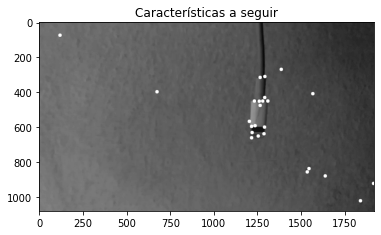

In [602]:
tracker = FeatureTracker(videoFrames)
tracker.detectFeatures(1)
tracker.plotFeaturesToTrack()

In [603]:
tracker.lukasKanadeTrack()
tracker.cleanFeatures()

cleaned 19


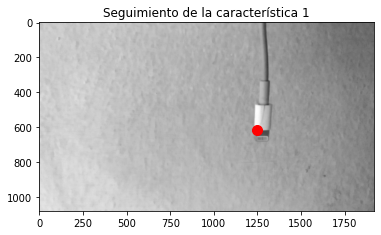

In [509]:
#Ahora examinemos una de las trayectorias
secondsToTrack = 5
featureToTrack = 1
tracker.plotTrack(featureToTrack,secondsToTrack)

In [604]:
#Probemos el resampleo
newSamplingFrequency = 250
tracker.resampleMotion(newSamplingFrequency)

918


<Figure size 432x288 with 0 Axes>

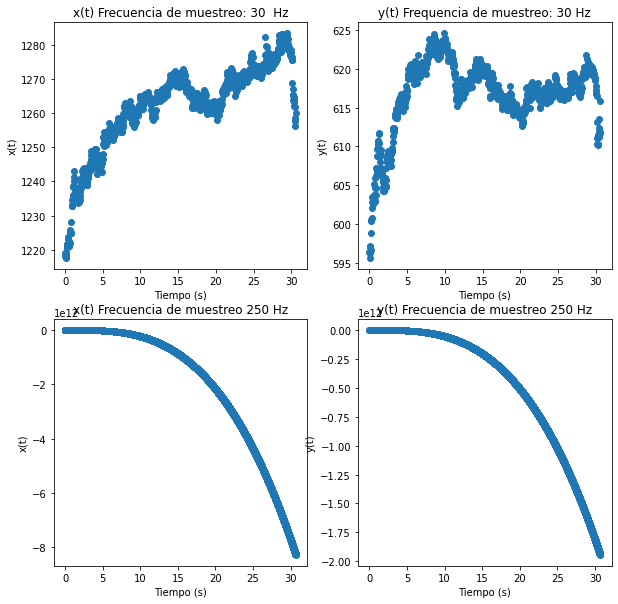

In [605]:
#Grafico del resampleo
tracker.plotResampledTrajectory(1)

In [292]:
[x,y]

[array([ 0.00000000e+00,  5.87785252e-01,  9.51056516e-01,  9.51056516e-01,
         5.87785252e-01,  1.22464680e-16, -5.87785252e-01, -9.51056516e-01,
        -9.51056516e-01, -5.87785252e-01, -2.44929360e-16]),
 array([ 1.        ,  0.80901699,  0.30901699, -0.30901699, -0.80901699,
        -1.        , -0.80901699, -0.30901699,  0.30901699,  0.80901699,
         1.        ])]

In [257]:
y

array([ 1.        ,  0.80901699,  0.30901699, -0.30901699, -0.80901699,
       -1.        , -0.80901699, -0.30901699,  0.30901699,  0.80901699,
        1.        ])

In [271]:
a = [1,2,3,4,5]
b = np.transpose(a)
np.transpose(a)

array([1, 2, 3, 4, 5])

In [377]:
tracker.trajectories[:,0,3]

array([1411.76257324, 1412.41259766, 1411.13391113, 1411.85400391,
       1411.50671387, 1411.25463867, 1411.16125488, 1411.02416992,
       1410.99890137, 1410.20068359, 1409.75585938, 1410.41882324,
       1412.2298584 , 1409.6854248 , 1409.80432129, 1409.1328125 ,
       1408.61230469, 1410.60009766, 1410.57763672, 1409.83154297,
       1409.94555664, 1409.70068359, 1408.8137207 , 1409.54418945,
       1409.23498535, 1409.30114746, 1408.6550293 , 1408.76281738,
       1409.3807373 , 1408.9708252 , 1409.59729004, 1409.54907227,
       1408.76794434, 1410.33605957, 1409.85205078, 1409.88977051,
       1410.46923828, 1410.48181152, 1410.46325684, 1411.29382324,
       1411.5012207 , 1411.21057129, 1411.49450684, 1406.31518555,
       1406.41357422, 1407.53344727, 1407.00830078, 1406.7052002 ,
       1407.01293945, 1406.98962402, 1407.35668945, 1407.60559082,
       1406.85595703, 1404.98950195, 1405.73583984, 1408.82556152,
       1408.99157715, 1408.1541748 , 1407.69677734, 1408.56237